In [1]:
import gym
import torch
import gym_nav
import numpy as np

import sys
sys.path.append('../')
from evaluation import *
from model_evaluation import *
from trajectories import *
%run ../evaluation 

from tqdm import tqdm

In [2]:
env_kwargs = {'num_objects': 0, 'rew_structure': 'goal',
              'task_structure': 3, 'wall_colors': 4, 'num_rays': 12, 'fov': 1,
              'character_reset_pos': 1,  'one_hot_obs': True, 
              'turn_speed': 0.5, 'move_speed': 15, 'max_steps': 500}
env = gym.make('NavEnv-v0', **env_kwargs)

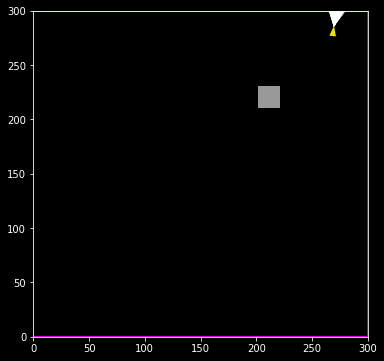

In [56]:
obs = env.reset()
env.render('human')

-0.6856505705034888


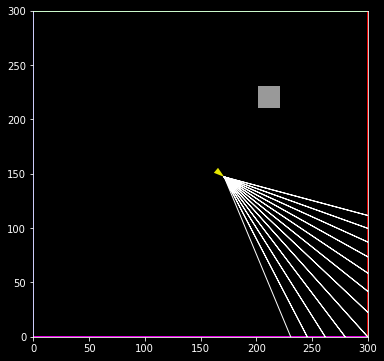

-0.6856505705034888


In [89]:
print(env.character.angle)
obs = env.step(1)
env.render('human')
print(env.character.angle)

In [2]:
from read_experiments import *

In [44]:

average_runs()

<function read_experiments.average_runs(trial_name, metric='return', ax=None, ret=False, ewm=0.01, label=None, cloud_alpha=0.1, cloud_by='minmax', ignore_first=16, color=None, medians=False, div_x_by_mil=False, ls=None, verbose=False, ignore_trial_idxs=[], skip_indexing=1)>

In [15]:
env_kwargs = {'num_objects': 0, 'rew_structure': 'goal',
              'task_structure': 3, 'wall_colors': 4, 'num_rays': 12, 'fov': 1,
              'character_reset_pos': 1,  'one_hot_obs': True}

env_kwargs = {'num_objects': 0, 'rew_structure': 'explore',
              'task_structure': 3, 'wall_colors': 4, 'num_rays': 12, 'fov': 1,
              'character_reset_pos': 1,  'one_hot_obs': True,
              'turn_speed': 0.5, 'move_speed': 10, 'max_steps': 500}

env_kwargs = {'num_objects': 0, 'rew_structure': 'explorepunish2', 'sub_goal_reward': 0.02,
              'task_structure': 3, 'wall_colors': 4, 'num_rays': 12, 'fov': 1,
              'character_reset_pos': 1,  'one_hot_obs': True,
              'turn_speed': 0.5, 'move_speed': 10, 'max_steps': 500}

# model, obs_rms = torch.load('../trained_models/ppo/nav_4wallexplore/nav_4wallexplore_batch128onehot_t0.pt')
# model, obs_rms = torch.load('../saved_models/4wallexplore/nav_4wallexplore_batch128faster20m_t1.pt')
# model, obs_rms = torch.load('../saved_models/4we_aux/nav_4wallexplore_batch128faster20mrewexplore_t0.pt')
# model, obs_rms = torch.load('../saved_models/4we_aux/nav_4wallexplore_batch128explorepunish_t0.pt')
# model, obs_rms = torch.load('../saved_models/4we_punish/nav_4wallexplore_ep0.1_t2.pt')
model, obs_rms = torch.load('../saved_models/4we_punish/nav_4wallexplore_2ep0.05_t0.pt')
# model, obs_rms = torch.load('../saved_models/4wefc_punish/nav_4wefc_2ep0.01_t0.pt')

res = evaluate(model, obs_rms, env_kwargs=env_kwargs, num_episodes=5, data_callback=nav_data_callback,
              verbose=2)

C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ep 0, rew tensor([[0.]])
ep 1, rew tensor([[0.]])
ep 2, rew tensor([[0.]])
ep 3, rew tensor([[0.]])
ep 4, rew tensor([[0.]])
 Evaluation using 0 episodes: mean reward nan



C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\14and\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Quantifying performance on explore task
Quantify by

* Search efficiency (how much space is covered in a platform reset based on number of steps in the reset)
* Memory effectiveness (are subsequent resets better able to recall where the platform was seen?)

In [44]:
def split_by_rew(targets_to_split, rews):
    '''
    Used to find when in an explore task the goal was reached based on
    when reward was earned. 

    For example, 
    res = evalu(...)
    ep_pos = split_by_ep(res['data']['pos'], res['rewards'])
    '''
    split_idxs = np.where(np.vstack(rews == 1))[0] + 1
    
    # if nothing to split
    if len(split_idxs) == 0:
        return [targets_to_split]

    split_targets = []
    for i in range(len(split_idxs)):
        if i == 0:
            done_targets = targets_to_split[:split_idxs[i]]
        else:
            done_targets = targets_to_split[split_idxs[i-1]:split_idxs[i]]
        split_targets.append(done_targets)
        
    if split_idxs[-1] != len(rews):
        split_targets.append(targets_to_split[split_idxs[-1]:])
        
    return split_targets


def compute_search_efficiency(pos, covered_distance=10):
    '''
    Compute search efficiency based on how many spots agent managed to get close to
    
    covered_distance: how close the agent had to get to a point to count as covered
        this should probably related to speed agent moves and goal size?
    '''
    
    test_points = np.stack(np.meshgrid(np.linspace(0, 300, 301), np.linspace(0, 300, 301))).reshape(2, -1).T
    unique_pos = np.unique(pos, axis=0)
    
    dists = []
    for p in unique_pos:
        dists.append(np.sqrt(np.sum((test_points - p) ** 2, axis=1)))
    min_dists = np.vstack(dists).min(axis=0)
    
    color_points = np.full(test_points.shape, False)
    color_points[min_dists < 10] = True
    color_points = color_points.all(axis=1).reshape(301, 301) #this can be plt.imshow'd to see what counts as visited
    num_covered_points = color_points.sum()
    
    total_points = 301*301
    cover_efficiency = num_covered_points / total_points / pos.shape[0]
    
    return cover_efficiency
    
    
def compute_eps_search_efficiency(all_pos, all_rew, ret_trials=False):
    '''
    Compute the mean and std search efficiency of an agent across multiple episodes
    Note we are assuming that all_pos and all_rew are already split by episode which
        they should be coming from an evaluate() call
        
    ret_trials: return individual values rather than mean and std, for example for boxplots    
    
    Ex. 
    res = evaluate(model, obs_rms, env_kwargs=env_kwargs, num_episodes=5, data_callback=nav_data_callback)
    compute_eps_search_efficiency(res['data']['pos'], res['rewards']
    '''
    
    explore_efficiencies = []

    for ep in range(len(all_rew)):
        rew = all_rew[ep]
        pos = all_pos[ep]

        split_pos = split_by_rew(pos, rew)
        split_rew = split_by_rew(rew, rew)

        for p in split_pos:
            explore_efficiencies.append(compute_search_efficiency(p))
            
    mean_eff = np.mean(explore_efficiencies)
    std_eff = np.std(explore_efficiencies)
    
    if ret_trials:
        return explore_efficiencies
    else:
        return mean_eff, std_eff

In [31]:
d = compute_eps_search_efficiency(res['data']['pos'], res['rewards'], ret_trials=True)

In [32]:
len(d)

19

In [33]:
len(res['data']['pos'])

10

In [17]:
env_kwargs = {'num_objects': 0, 'rew_structure': 'goal',
              'task_structure': 3, 'wall_colors': 4, 'num_rays': 12, 'fov': 1,
              'character_reset_pos': 1,  'one_hot_obs': True,
              'turn_speed': 0.5, 'move_speed': 10, 'max_steps': 500}

eps = [0.01, 0.02, 0.04]
mults = [2, 5]
args = [3, 5, 7]

# all_means = {}
# all_stds = {}
all_vals
for mult in mults:
    for arg in args:
        for ep in eps:
            exp_name = f'nav_4wefc_ep{ep}mult{mult}arg{arg}'
            dict_key = f'ep{ep}mult{mult}arg{arg}'
            
            if dict_key in all_means:
                continue
            
            means = []
            stds = []
            for trial in tqdm(range(3)):
                save_file = exp_name + f'_t{trial}.pt'
                model, obs_rms = torch.load(f'../saved_models/4wefc_punish/{save_file}')
                res = evaluate(model, obs_rms, env_kwargs=env_kwargs, num_episodes=10, data_callback=nav_data_callback)

                mean, std = compute_eps_search_efficiency(res['data']['pos'], res['rewards'])
                means.append(mean)
                stds.append(std)

            all_means[dict_key] = means
            all_stds[dict_key] = stds

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:40<00:00, 13.43s/it]


In [18]:
pickle.dump([all_means, all_stds], open('data/explore/explore_efficiencies', 'wb'))

In [22]:
pplt.rc.reset()

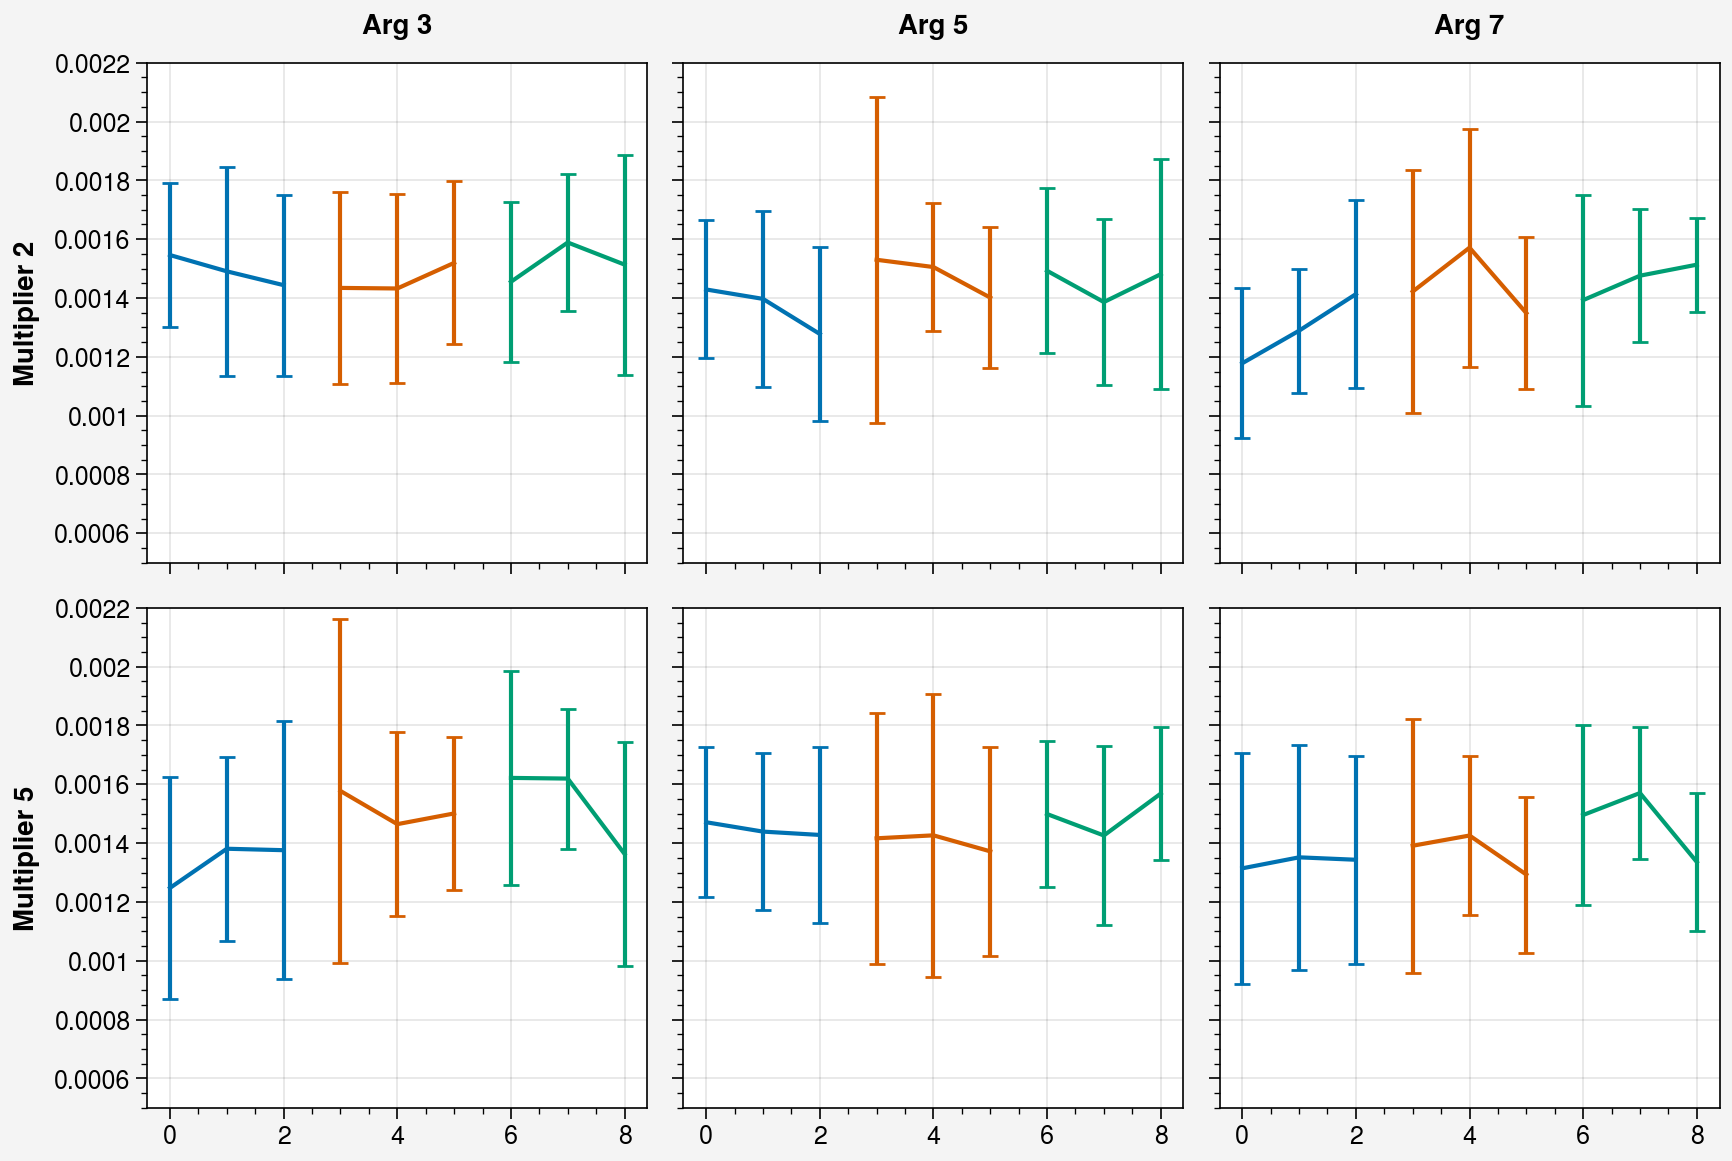

In [28]:
eps = [0.01, 0.02, 0.04]
mults = [2, 5]
args = [3, 5, 7]

fig, ax = pplt.subplots(nrows=2, ncols=3, sharey=True)

for i, mult in enumerate(mults):
    for j, arg in enumerate(args):
        for k, ep in enumerate(eps):
            dict_key = f'ep{ep}mult{mult}arg{arg}'
            
            means = all_means[dict_key]
            stds = all_stds[dict_key]
            ax[i, j].errorbar(np.arange(3) + 3*k, means, stds)
            
ax.format(leftlabels=[f'Multiplier {mult}' for mult in mults],
          toplabels=[f'Arg {arg}' for arg in args],
          ylim=[0.0005, 0.0022])

In [92]:
env_kwargs = {'num_objects': 0, 'rew_structure': 'goal',
              'task_structure': 3, 'wall_colors': 4, 'num_rays': 12, 'fov': 1,
              'character_reset_pos': 1,  'one_hot_obs': True,
              'turn_speed': 0.5, 'move_speed': 10, 'max_steps': 500}

# model, obs_rms = torch.load('../saved_models/4wefc_punish/nav_4wefc_ep0.01mult5arg7_t1.pt')
model, obs_rms = torch.load('../saved_models/4we_punish/nav_4wallexplore_ep0.02_t2.pt')
res = evaluate(model, obs_rms, env_kwargs=env_kwargs, num_episodes=10, data_callback=nav_data_callback,
              verbose=2)

C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ep 0, rew tensor([[0.]])
ep 1, rew tensor([[0.]])
ep 2, rew tensor([[4.]])
ep 3, rew tensor([[2.]])
ep 4, rew tensor([[6.]])
ep 5, rew tensor([[1.]])
ep 6, rew tensor([[0.]])
ep 7, rew tensor([[2.]])
ep 8, rew tensor([[0.]])
ep 9, rew tensor([[3.]])
 Evaluation using 0 episodes: mean reward nan



C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\14and\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [96]:
ep = 1
rew = res['rewards'][ep]
pos = res['data']['pos'][ep]
angle = res['data']['angle'][ep]

split_pos = split_by_rew(pos, rew)
split_angle = split_by_rew(angle, rew)
split_rew = split_by_rew(rew, rew)
print(len(split_pos))

1


0.0009996987359883762


(Figure(nrows=1, ncols=1, refwidth=2.5),
 SubplotGrid(nrows=1, ncols=1, length=1))

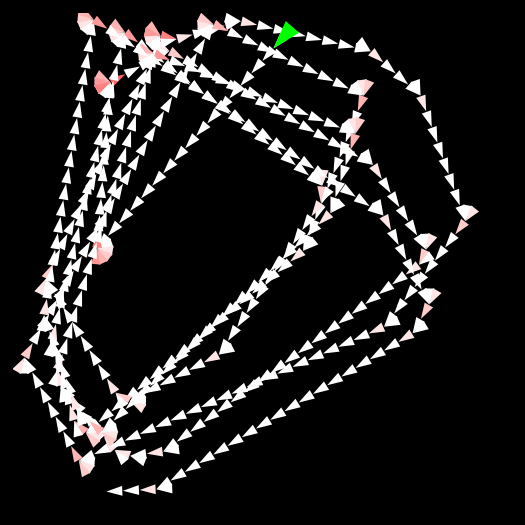

In [97]:
i = 0

p = split_pos[i]
a = split_angle[i]
r = split_rew[i]
print(compute_search_efficiency(p))

draw_trajectory(p, a, rew=r)



# !!Check whether episodes where goal is found and refound the RNN hidden state looks different. Or check whether receiving the goal reached observation makes significant change in RNN

(Figure(nrows=1, ncols=1, refwidth=2.5),
 SubplotGrid(nrows=1, ncols=1, length=1))

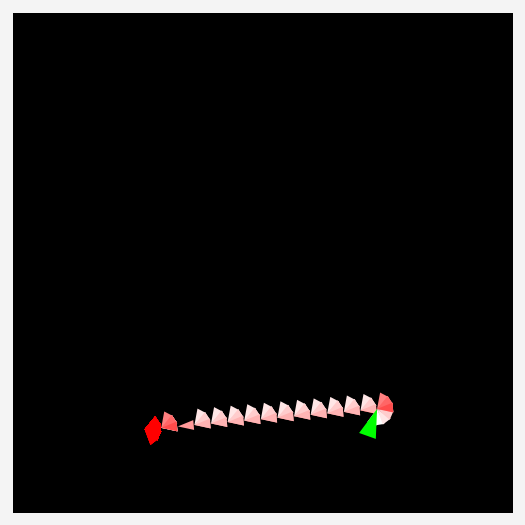

In [14]:
i = 1

pos = res['data']['pos'][i]
angle = res['data']['angle'][i]

draw_trajectory(pos, angle)

In [30]:
envs = simple_vec_envs(obs_rms, env_kwargs=env_kwargs)

In [31]:
res = evaluate_steps(model, envs, num_steps=100, data_callback=nav_data_callback)

In [33]:
env = envs.envs[0]
env.visited_positions

array([[239.23651845,  97.09652654],
       [239.23651845,  97.09652654],
       [229.81684411, 100.45356917],
       ...,
       [         inf,          inf],
       [         inf,          inf],
       [         inf,          inf]])

In [38]:
visited_distanced = np.full((env.visited_positions.shape[0]), False)

In [39]:
env.visited_positions[visited_distanced]

array([], shape=(0, 2), dtype=float64)

In [43]:
infs = (env.visited_positions == np.inf).all(axis=1)
check_pos = env.visited_positions[~visited_distanced & ~infs]

In [46]:
pos = env.character.pos
check_dists = np.sqrt(np.sum((check_pos - pos)**2, axis=1))

In [22]:
pos = env.character.pos
env.visited_positions[env.visited_idx] = pos.copy()
env.visited_idx += 1

lim_idx = int(np.clip(env.visited_idx-10, 0, np.inf))

if lim_idx > 0:
    dists = env.visited_positions[:lim_idx] - pos
    dist = np.min(np.sum(dists**2, axis=1))
    dist = np.sqrt(dist)

    # This pretty much goes to 0 around dist of 50, which is tuned
    #  to a move speed of 10
    punish = -np.exp(-dist/10) * env.sub_goal_reward


# Explore punish

In [20]:
env_kwargs = {'num_objects': 0, 'rew_structure': 'explorepunish',
              'task_structure': 3, 'wall_colors': 4, 'num_rays': 12, 'fov': 1,
              'character_reset_pos': 1,  'one_hot_obs': True,
              'turn_speed': 0.5, 'move_speed': 10, 'max_steps': 500}
env_kwargs = {'num_objects': 0, 'rew_structure': 'explorepunish1_explorebonus',
              'task_structure': 3, 'wall_colors': 4, 'num_rays': 12, 'fov': 1,
              'character_reset_pos': 1,  'one_hot_obs': True,
              'turn_speed': 0.5, 'move_speed': 10, 'max_steps': 500,
              'bonus_multiplier': 5, 'explore_punish_arg': 5}

In [21]:
env = gym.make('NavEnv-v0', **env_kwargs)
env.reset()
# 

array([0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.66906832, 0.64132893, 0.61992

In [22]:
env.visited_distanced[:20]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [23]:
env.visited_positions

array([[inf, inf],
       [inf, inf],
       [inf, inf],
       ...,
       [inf, inf],
       [inf, inf],
       [inf, inf]])

(array([0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.31967959, 0.24679482, 0.2021

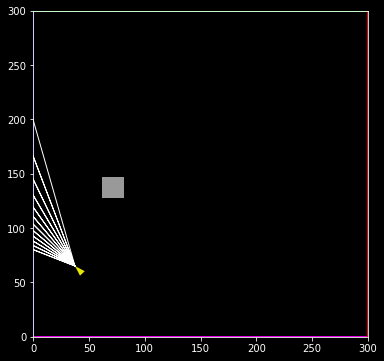

In [68]:
print(env.step(1))
env.render('human')

# Test explore env

In [2]:
env = gym.make('ExploreNav-v0', obs_set=2)

In [3]:
env.reset()

array([0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.44548342, 0.43895384, 0.43559

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.49018817, 0.53828034, 0.6014

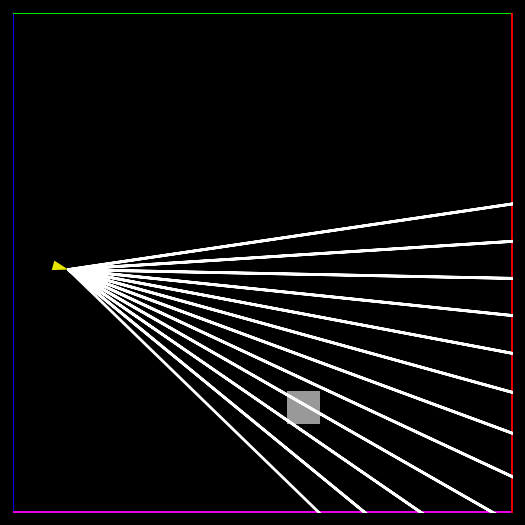

In [41]:
fig, ax = pplt.subplots()
print(env.step(1))
env.render('human', ax=ax)

ax.format(xlim=[0, 300], ylim=[0, 300])

# Test shortcut env

In [21]:
env = gym.make('ShortcutNav-v0', shortcut_probability=0.5)

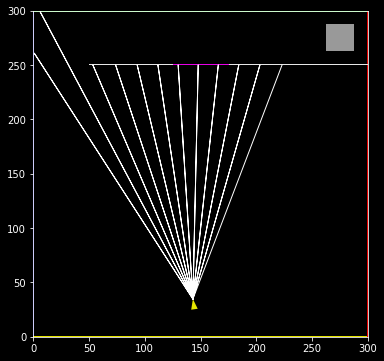

In [30]:

env.reset()
env.render('human')

In [5]:
env.character.ray_dists

array([264.05469338, 273.8630102 , 259.0769037 , 247.43497454,
       238.37763417, 231.51000444, 226.55536371, 223.32585207,
       221.70421464, 221.63309706, 223.11000717, 226.18709902])

In [8]:
char = env.character


In [9]:
fov_start = char.angle - char.fov/2
fov_end = fov_start + char.fov

ray_angles = np.linspace(fov_start, fov_end, char.num_rays, endpoint=False)
ray_mults = np.array([np.cos(ray_angles), np.sin(ray_angles)]).T
ray_ends = ray_mults * char.ray_max_len + char.pos
ray_starts = np.full((char.num_rays, 2), char.pos)

x1 = ray_starts[:, 0].reshape(-1, 1)
y1 = ray_starts[:, 1].reshape(-1, 1)
x2 = ray_ends[:, 0].reshape(-1, 1)
y2 = ray_ends[:, 1].reshape(-1, 1)

#Compute intersect metrics
epsilon = 1e-8
denom = (char.y4-char.y3)*(x2-x1) - (char.x4-char.x3)*(y2-y1) + 1e-8
ua = ((char.x4-char.x3)*(y1-char.y3) - (char.y4-char.y3)*(x1-char.x3)) / denom
ub = ((x2-x1)*(y1-char.y3) - (y2-y1)*(x1-char.x3)) / denom

#Compute x y intersects (they ARE both supposed to be ua)
x = x1 + ua*(x2-x1)
y = y1 + ua*(y2-y1)

#Compute distances to intersects
dists = np.sqrt((x - char.pos[0])**2 + (y - char.pos[1])**2)

#Only keep distances with valid intersects
mults = np.full(x.shape, 1.)
mults[((ua < 0) | (ua > 1) | (ub < 0) | (ub > 1))] = np.inf

#We get np.nan where lines are parallel which throws off the argmin
# Setting parallel to inf should fix the issue
dists[np.isnan(dists)] = np.inf

wall_idxs = np.argmin(mults*dists, axis=1)
wall_idxs2 = np.stack([np.arange(char.num_rays), wall_idxs])

# inter_x = x[wall_idxs2[0], wall_idxs2[1]]
# inter_y = y[wall_idxs2[0], wall_idxs2[1]]


In [11]:
ray_dists = dists[wall_idxs2[0], wall_idxs2[1]]
ray_colors = list(map(lambda x: x.color, char.vis_wall_refs[wall_idxs]))


# Behavior in shortcut

In [92]:
import sys
sys.path.append('../')
from model_evaluation import *
from trajectories import *
from evaluation import *

model, obs_rms = torch.load('../saved_models/shortcuts/shortcutnav_shortcutprob0.4batch32_t0.pt')

res = evaluate(model, obs_rms, num_episodes=5, data_callback=nav_data_callback,
              verbose=2, env_name='ShortcutNav-v0')

C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ep 0, rew tensor([[1.]])
ep 1, rew tensor([[1.]])
ep 2, rew tensor([[1.]])
ep 3, rew tensor([[1.]])
ep 4, rew tensor([[1.]])
 Evaluation using 0 episodes: mean reward nan



C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\14and\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [112]:
model, obs_rms = torch.load('../saved_models/shortcuts/shortcutnav_shortcutprob0.2batch128_t2.pt')

res = evaluate(model, obs_rms, num_episodes=5, data_callback=nav_data_callback,
              verbose=2, env_name='ShortcutNav-v0', env_kwargs={'shortcut_probability': 0})
res2 = evaluate(model, obs_rms, num_episodes=5, data_callback=nav_data_callback,
              verbose=2, env_name='ShortcutNav-v0', env_kwargs={'shortcut_probability': 1})

C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ep 0, rew tensor([[1.]])
ep 1, rew tensor([[1.]])
ep 2, rew tensor([[1.]])
ep 3, rew tensor([[1.]])
ep 4, rew tensor([[1.]])
 Evaluation using 0 episodes: mean reward nan

ep 0, rew tensor([[1.]])
ep 1, rew tensor([[1.]])


C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\14and\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ep 2, rew tensor([[1.]])
ep 3, rew tensor([[1.]])
ep 4, rew tensor([[1.]])
 Evaluation using 0 episodes: mean reward nan



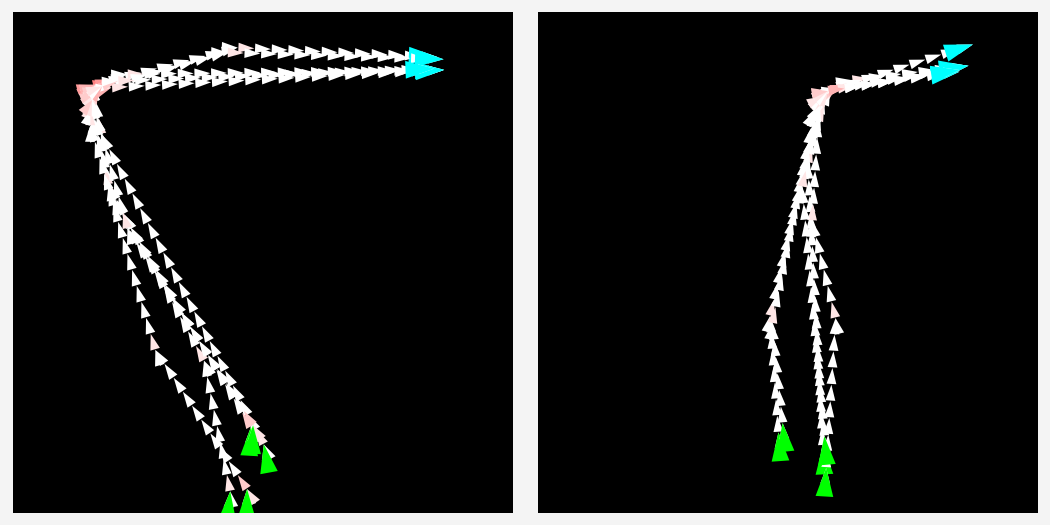

In [113]:
fig, ax = pplt.subplots(ncols=2)

pos = res['data']['pos']
angle = res['data']['angle']

pos2 = res2['data']['pos']
angle2 = res2['data']['angle']

for i in range(5):
    p = pos[i]
    a = angle[i]
    draw_trajectory(p, a,  ax=ax[0])
    
    p = pos2[i]
    a = angle2[i]
    draw_trajectory(p, a,  ax=ax[1])

In [109]:
print(np.mean([len(p) for p in pos]))
print(np.mean([len(p) for p in pos2]))

56.2
37.2


In [36]:
%run gradients

In [45]:
agent, envs, rollouts = initialize_ppo_training(model, obs_rms, 'ShortcutNav-v0', num_steps=100)
actor_critic = agent.actor_critic
res = populate_rollouts_aux(actor_critic, envs, rollouts)

In [46]:
with torch.no_grad():
    next_value = actor_critic.get_value(
        rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
        rollouts.masks[-1]).detach()

(Figure(nrows=1, ncols=1, refwidth=2.5),
 SubplotGrid(nrows=1, ncols=1, length=1))

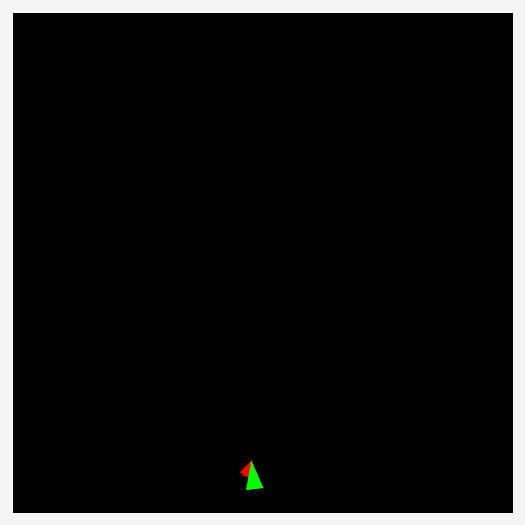

In [21]:
i = 0

pos = res['data']['pos'][i]
angle = res['data']['angle'][i]

draw_trajectory(pos, angle)
